<img src='http://greenteapress.com/thinkstats/think_stats_comp.png'>

## Question: Are Men Taller Than Women? 
---

<big>

<br>

The difference between two distributions is known as the 'effect'
We are interesting in 
- measuring the effect size
- understanding whether this is *significant*

Essentially we want to know 
- if measuring an effect this large could have happened by chance (for e.g. sampling error)
- the pattern implied by the effect is real and will hold if the test is repeated

Going back to our question, we can look at it another way:
If men are taller than women, I could reliably use height to predict gender.

<br>

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as pyplot
from ipywidgets import interact, fixed
import seaborn as sns

sns.set_context('notebook')
sns.set_style('darkgrid')

np.random.seed(17)

<big>

<br>

## Heights of human adult males and females
---

Heights (and weights, like many other such things) follow the Normal Distribution.
Let's assume that
- For males, the mean height $\mu_m = 175$ and standard deviation $\sigma_m = 7.7$
- For females, the mean height $\mu_f = 160$ and standard deviation $\sigma_f = 7.3$

```python
mu1, sig1 = 175, 7.7
mu2, sig2 = 160, 7.3
```
<br>

We will create Distribution objects using these parameters with `scipy.stats.norm()`, and then use their methods like

- `pdf`: to visualize the probability density 
- `rvs`: to generate a sample of data for comparison

<br>

In [2]:
mu1, sig1 = 175, 7.7
mu2, sig2 = 160, 7.3

In [3]:
# Create Distribution objects
# - give us access to pdf, cdf etc.
male_height = stats.norm(loc=mu1, scale=sig1)
female_height = stats.norm(loc=mu2, scale=sig2)

In [4]:
type(male_height)

scipy.stats._distn_infrastructure.rv_continuous_frozen

In [6]:
x_axis = np.linspace(start=130, stop=210, num=100)

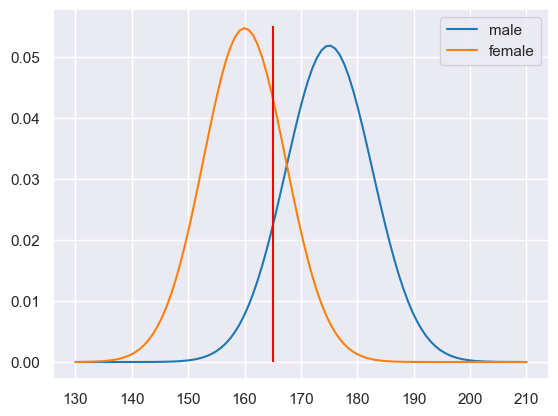

In [16]:
# Plot the PDFs for the 2 distributions

ax = pd.Series(data=male_height.pdf(x_axis), 
               name='male', 
               index=x_axis).plot()

pd.Series(data=female_height.pdf(x_axis), 
          name='female', 
          index=x_axis).plot(ax=ax)

ax.legend();
ax.vlines(x=165, ymin=0, ymax=0.055, color='r')

```python
if height > threshold:
    gender = 'male'
else:
    gender = 'female'
```

<big>

<br>

---

Let's assume for now that those are the **true distributions for the population.**  

> Of course, in real life we never observe the true population distribution.  We generally have to work with a random sample.

For our analysis, let's generate random samples from the population distributions - we will assume that these are totally random, totally representative samples!

<br>


In [9]:
male_sample = male_height.rvs(1000)
female_sample = female_height.rvs(1000)

In [10]:
male_sample[:15].round(2)

array([177.13, 160.72, 179.8 , 183.82, 182.99, 189.53, 174.14, 172.21,
       176.14, 171.63, 191.72, 183.87, 161.  , 173.94, 179.16])

In [11]:
female_sample[:15].round(2)

array([161.5 , 157.28, 164.83, 157.75, 161.11, 152.73, 156.92, 169.73,
       162.14, 151.47, 145.59, 166.03, 154.21, 161.26, 153.52])

Both samples are NumPy arrays.  Now we can compute sample statistics like the mean and standard deviation.

In [12]:
mean1, std1 = male_sample.mean().round(1), male_sample.std().round(1)
mean1, std1

(np.float64(175.2), np.float64(7.8))

The sample mean is close to the population mean, but not exact, as expected.

In [13]:
mean2, std2 = female_sample.mean().round(1), female_sample.std().round(1)
mean2, std2

(np.float64(160.5), np.float64(7.4))

<br>

## Describing the magnitude of the difference between distributions

---
### 1. Difference in Means

In [14]:
difference_in_means = mean1 - mean2
difference_in_means.round(1) # in cm

np.float64(14.7)

<br>    

**On average, men are 14-15 centimeters taller.**  

For some applications, that would be a good way to describe the difference, but there are a few problems:

<br>

* Without knowing more about the distributions (like the standard deviations) it's **hard to interpret whether a difference like 15 cm is a lot or not.**

* The magnitude of the difference **depends on the units of measure**, making it hard to compare across different studies.

<br>

### 2. Overlap / Threshold
---

An alternative way to express the difference between distributions is to **see how much they overlap.**  
If there is no overlap, we can conclude the two distributions are *significantly different*

To define overlap, we may **choose a threshold between the two means.** 
One way to use this threshold is as a simple model.

```python
if (height_of_person > thresh):
    print("this person is likely to be male")
else:
    print("this person is likely to be female")
```

Then, based on the error rate of the model - we can conclude that there is an effect and it is large.

In [17]:
simple_thresh = (mean1 + mean2) / 2
simple_thresh.round(1)

np.float64(167.8)

A better, but slightly more complicated threshold is the place where the PDFs cross.

In [18]:
thresh = (std1 * mean2 + std2 * mean1) / (std1 + std2)
thresh.round(1)

np.float64(167.7)

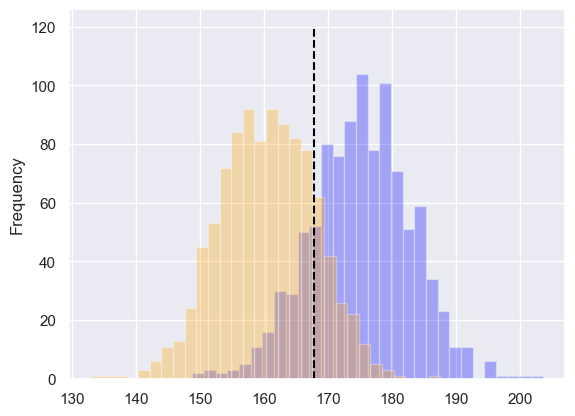

In [19]:
ax = pd.Series(male_sample).plot.hist(color='blue', alpha=0.3, bins=30)
pd.Series(female_sample).plot.hist(color='orange', ax=ax, alpha=0.3, bins=30)
ax.vlines(x=simple_thresh, ymin=0, ymax=120, color='black', linestyle='--');

<big>
<br>

If men are taller than women, the overlap should be very small.  
There should be a very small number of men and women on the wrong side of the threshold.

Let's measure this 'misclassification' rate 

In [20]:
male_below_thresh = sum(male_sample < thresh)
female_above_thresh = sum(female_sample > thresh)

<big>
    
<br>

The "overlap" is the total area under the curves that ends up on the wrong side of the threshold.   
Then, we can calculate the fraction of people who would be misclassified if you tried to use height to guess gender.
    
<br>  

In [25]:
overlap = (male_below_thresh / len(male_sample)) + (female_above_thresh / len(female_sample))

misclassification_rate = overlap / 2
misclassification_rate

np.float64(0.16899999999999998)

<big>

### 3. Computational Approach

If men are taller than women, a randomly chosen male should be taller than a randomly chosen female (over a large number or experiments)

<br>

In [49]:
pd.Series([1 if 
           male_height.rvs(1) > female_height.rvs(1) 
           else 0 
           for x 
           in range(2000)]).mean().round(3)

np.float64(0.926)

## 4. Statistical Tests


In [50]:
from scipy.stats import ttest_ind

In [52]:
ttest_ind(male_sample, 
          female_sample)

TtestResult(statistic=np.float64(43.07816317951488), pvalue=np.float64(2.5688146631442475e-287), df=np.float64(1998.0))

<Axes: ylabel='Frequency'>

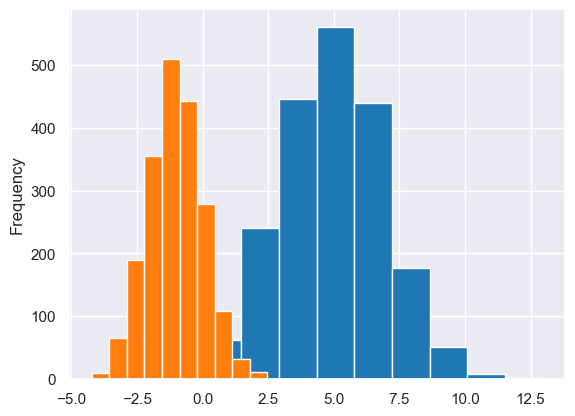

In [72]:
d1 = stats.norm.rvs(loc=5, scale=2, size=2000)
d2 = stats.norm.rvs(loc=-1, scale=1, size=2000)

ax = pd.Series(d1).plot.hist()
pd.Series(d2).plot.hist(ax=ax)

In [73]:
ttest_ind(
    d1, 
    d2
)

TtestResult(statistic=np.float64(119.55769139338904), pvalue=np.float64(0.0), df=np.float64(3998.0))

In [74]:
df_titanic = sns.load_dataset('titanic')

In [75]:
df_titanic

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


<Axes: xlabel='fare', ylabel='sex'>

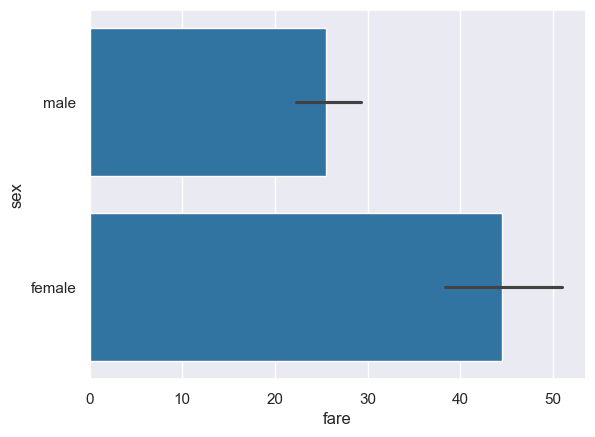

In [80]:
sns.barplot(x='fare', y='sex', data=df_titanic)

In [81]:
ttest_ind(
    df_titanic.query("sex=='male'").loc[:, 'fare'],
    df_titanic.query("sex=='female'").loc[:, 'fare']
)

TtestResult(statistic=np.float64(-5.529140269385719), pvalue=np.float64(4.230867870042998e-08), df=np.float64(889.0))

<Axes: ylabel='Frequency'>

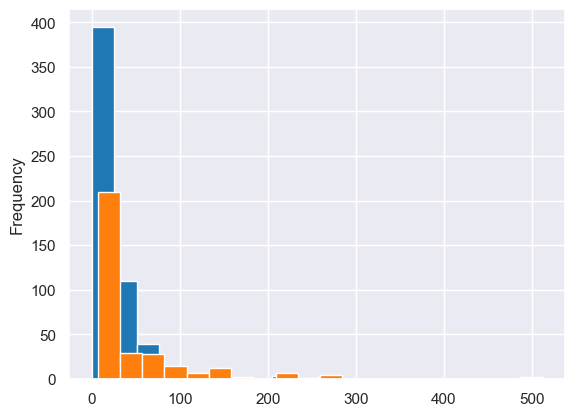

In [79]:
df_titanic.query("sex=='male'").loc[:, 'fare'].plot.hist(bins=20)
df_titanic.query("sex=='female'").loc[:, 'fare'].plot.hist(bins=20)